In [1]:
%matplotlib inline

### Canny Edge Detection

In [ ]:
# import the necessary packages
import numpy as np
import argparse
import glob
import cv2

def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)

	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)

	# return the edged image
	return edged



# imagePath = r"C:\Users\sohil\Desktop\c.png"
imagePath = r"C:\Users\sohil\AnacondaProjects\JobTask\example_output\draw_boundary1.jpg"
# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread(imagePath)
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# apply Canny edge detection using a wide threshold, tight
# threshold, and automatically determined threshold
wide = cv2.Canny(blurred, 20, 150, L2gradient = True)
tight = cv2.Canny(blurred, 225, 250)
auto = auto_canny(blurred)
a = image - cv2.cvtColor(wide, cv2.COLOR_GRAY2BGR)
print(type(a))
a[a <= 0] = 0
# image = a
# show the images
cv2.imshow("Original",a )
cv2.imshow("Edges", np.hstack([wide ]))
cv2.waitKey(0)

<class 'numpy.ndarray'>


### Segmentation

In [ ]:
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import argparse
import cv2

# image = cv2.imread(imagePath)
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51) - cv2.cvtColor(wide, cv2.COLOR_GRAY2BGR)
shifted[shifted <= 0 ] = 0
# cv2.imshow("Input", image)
cv2.imshow("Shifted", shifted)
# convert the mean shift image to grayscale, then apply
# Otsu's thresholding
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
cv2.imshow("Thresh", thresh)

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, indices=False, min_distance=20,
	labels=thresh)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue

	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255

	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)[-2]
	c = max(cnts, key=cv2.contourArea)

	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

# show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)

### Histogram

In [22]:
img = cv2.imread(imagePath)
hist = cv2.calcHist([img],[0],None,[256],[0,256])

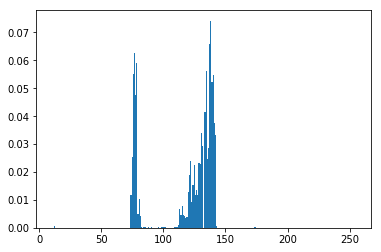

-1

In [42]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
imagePath = r"C:\Users\sohil\AnacondaProjects\JobTask\example_output\extract_field748.jpg"
img = cv2.imread(imagePath)
shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

# color = ('b','g','r')
# for i,col in enumerate(color):
#     histr = cv2.calcHist([img],[i],None,[256],[0,256])
#     plt.plot(histr,color = col)
#     plt.xlim([0,256])

# filtered = gray[~is_outlier(gray)]
# # Plot the results
# fig, (ax1, ax2) = plt.subplots(nrows=2)

# ax1.hist(gray .ravel(), bins=255, range= (0, 255))
# ax1.set_title('Original')


plt.hist(gray .ravel(), bins=255, range= (10, 255), density=True)
plt.show()


# density = gaussian_kde(gray)
# xs = np.linspace(0,8,200)
# density.covariance_factor = lambda : .25
# density._compute_covariance()
# plt.plot(xs,density(xs))
# plt.show()


# ax2.hist(filtered)
# ax2.set_title('Without Outliers')

cv2.imshow("Gray", gray)
cv2.waitKey(0)

In [36]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [43]:
import numpy as np
from skimage import io, morphology, measure
from sklearn.cluster import KMeans

img = io.imread(imagePath)

rows, cols, bands = img.shape
X = img.reshape(rows*cols, bands)

kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
labels = kmeans.labels_.reshape(rows, cols)

for i in np.unique(labels):
    blobs = np.int_(morphology.binary_opening(labels == i))
    color = np.around(kmeans.cluster_centers_[i])
    count = len(np.unique(measure.label(blobs))) - 1
    print('Color: {}  >>  Objects: {}'.format(color, count))

Color: [129. 128. 102.]  >>  Objects: 34
Color: [0. 0. 0.]  >>  Objects: 1
Color: [113. 114.  92.]  >>  Objects: 34
Color: [143. 143. 114.]  >>  Objects: 15
Color: [62. 88. 64.]  >>  Objects: 5


C:\Users\sohil\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


(640, 640)
Number of objects is 6 


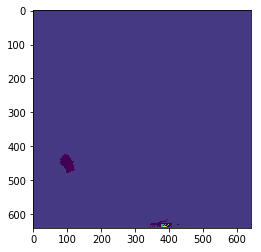

In [54]:
import scipy

fname='index.png'
blur_radius = 1.0
threshold = 50

imagePath = r"C:\Users\sohil\AnacondaProjects\JobTask\example_output\extract_field751.jpg"
img = scipy.misc.imread(imagePath) # gray-scale image
shifted = cv2.pyrMeanShiftFiltering(image, 21, 51)
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

print(gray.shape)

# smooth the image (to remove small objects)

imgf = gray #ndimage.gaussian_filter(img, blur_radius)
threshold = 20

# find connected components
labeled, nr_objects = ndimage.label(imgf > threshold) 
print("Number of objects is %d " % nr_objects)

# plt.imsave('/tmp/out.png', labeled)
plt.imshow(labeled)

plt.show()